In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split

c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.2)
  from scipy.sparse import csr_matrix, issparse


In [2]:
image_dir = "Data\data-20260214T164319Z-1-001\data\images"
label_dir = "Data\data-20260214T164319Z-1-001\data\labels"

image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

print("Number of images:", len(image_files))
print("Number of labels:", len(label_files))

Number of images: 306
Number of labels: 456


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\saifk\AppData\Local\Temp\ipykernel_22656\2792036964.py:1: SyntaxWarning: invalid escape sequence '\d'
  image_dir = "Data\data-20260214T164319Z-1-001\data\images"
C:\Users\saifk\AppData\Local\Temp\ipykernel_22656\2792036964.py:2: SyntaxWarning: invalid escape sequence '\d'
  label_dir = "Data\data-20260214T164319Z-1-001\data\labels"


In [3]:
with rasterio.open(os.path.join(image_dir, image_files[0])) as src:
    sample_image = src.read()  

sample_image = np.transpose(sample_image, (1, 2, 0))  # convert to (H, W, C)

sample_mask = cv2.imread(os.path.join(label_dir, label_files[0]), 0)

print("Image shape:", sample_image.shape)
print("Mask shape:", sample_mask.shape)

sample_image = sample_image.astype(np.float32)

for c in range(sample_image.shape[-1]):
    band = sample_image[:, :, c]
    min_val = band.min()
    max_val = band.max()
    if max_val > min_val:
        sample_image[:, :, c] = (band - min_val) / (max_val - min_val)


Image shape: (128, 128, 12)
Mask shape: (128, 128)


c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


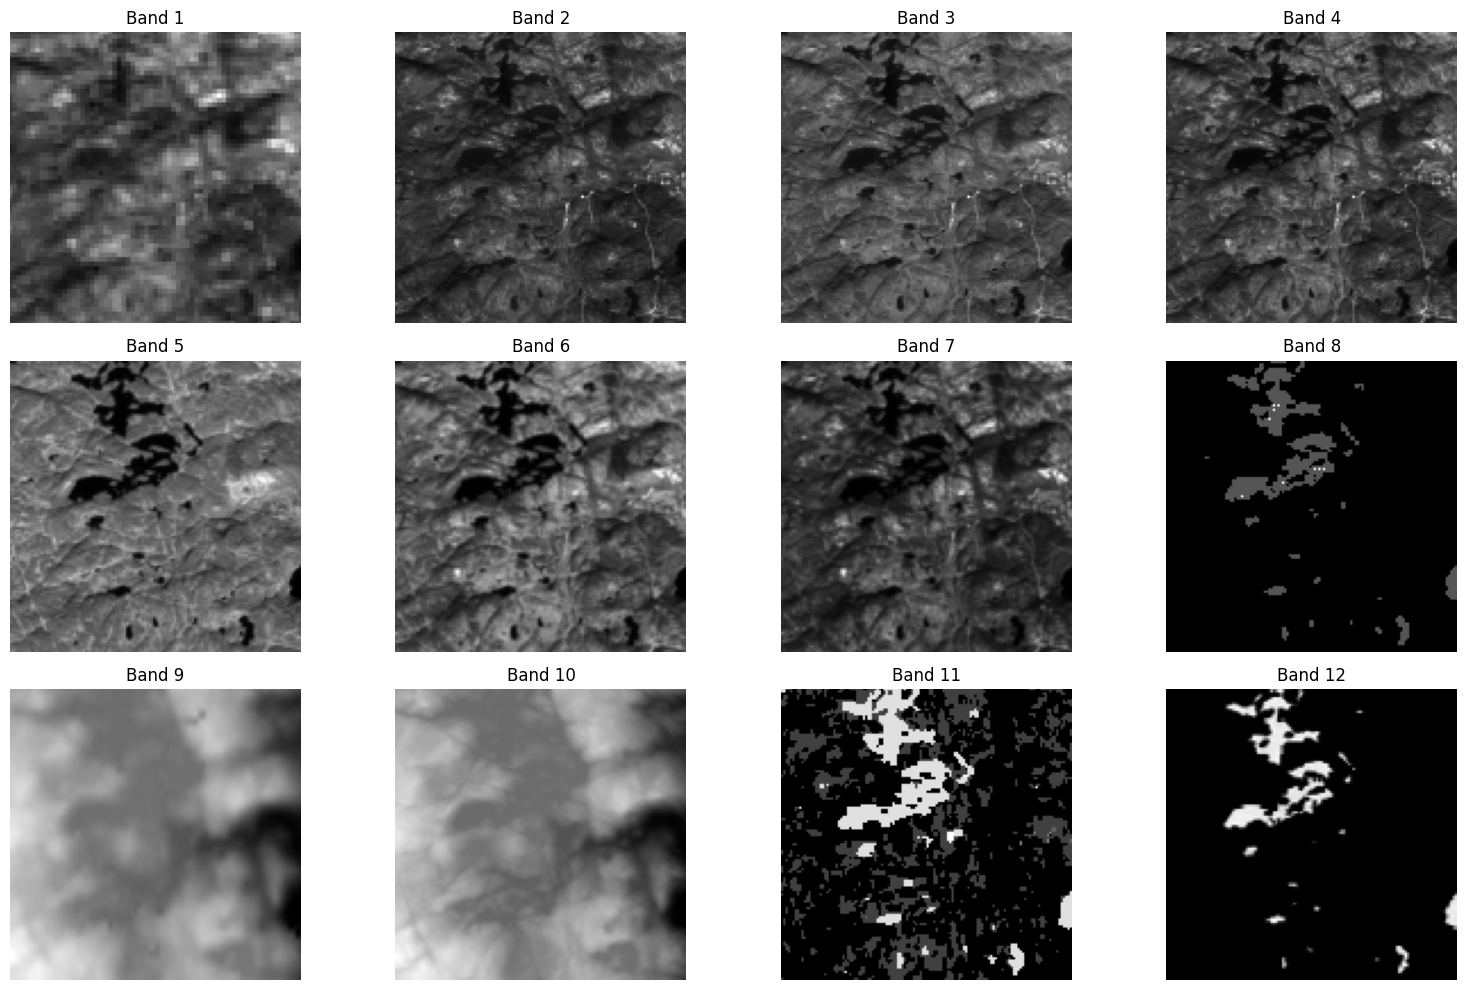

In [4]:
plt.figure(figsize=(16,10))

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(sample_image[:,:,i], cmap='gray')
    plt.title(f'Band {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


### Model Arch

In [17]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))

        bridge = self.bridge(self.pool3(d3))

        u3 = self.up3(bridge)
        u3 = self.conv3(torch.cat([u3, d3], dim=1))

        u2 = self.up2(u3)
        u2 = self.conv2(torch.cat([u2, d2], dim=1))

        u1 = self.up1(u2)
        u1 = self.conv1(torch.cat([u1, d1], dim=1))

        return self.final(u1)


### Testing Diffrent Channels 

In [40]:
bands_A = list(range(12))
bands_B = [0, 1, 4, 5, 6, 11]
bands_C = [3, 2, 1]  # R,G,B
bands_D = [4, 5, 6]
bands_E = [0, 1, 4, 5, 6, 11]  # + NDWI computed later


In [41]:
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir, selected_bands, add_ndwi=False):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))
        self.selected_bands = selected_bands
        self.add_ndwi = add_ndwi

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)

        with rasterio.open(img_path) as src:
            image = src.read()

        image = np.transpose(image, (1,2,0)).astype(np.float32)

        image = image[:, :, self.selected_bands]

        if self.add_ndwi:
            green = image[:, :, 2] if 2 in self.selected_bands else image[:, :, 1]
            nir = image[:, :, 4] if 4 in self.selected_bands else image[:, :, -1]

            ndwi = (green - nir) / (green + nir + 1e-8)
            ndwi = np.expand_dims(ndwi, axis=-1)

            image = np.concatenate([image, ndwi], axis=-1)

        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        image = torch.tensor(image).permute(2,0,1)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask


In [42]:
def train_model(selected_bands, add_ndwi=False, epochs=15):

    dataset = WaterDataset(image_dir, label_dir, selected_bands, add_ndwi)
    
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)

    in_channels = len(selected_bands) + (1 if add_ndwi else 0)
    model = UNet(in_channels=in_channels, out_channels=1).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 , weight_decay= 1e-4)
    criterion = nn.BCEWithLogitsLoss()

    best_val_iou = 0

    for epoch in range(epochs):
        model.train()
        train_iou = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            iou, _ = calculate_metrics(preds, masks)
            train_iou += iou

        train_iou /= len(train_loader)

        # Validation
        model.eval()
        val_iou = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                preds = (torch.sigmoid(outputs) > 0.5).float()

                iou, _ = calculate_metrics(preds, masks)
                val_iou += iou

        val_iou /= len(val_loader)

        print(f"Epoch {epoch+1}: Train IoU={train_iou:.4f} | Val IoU={val_iou:.4f}")

        if val_iou > best_val_iou:
            best_val_iou = val_iou

    return best_val_iou


In [44]:
results = {}

results["All 12"] = train_model(bands_A)
results["6 Water Bands"] = train_model(bands_B)
results["RGB"] = train_model(bands_C)
results["NIR+SWIR"] = train_model(bands_D)
results["6 Bands + NDWI"] = train_model(bands_B, add_ndwi=True)

print("\nFinal Validation IoU Comparison:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


Epoch 1: Train IoU=0.3843 | Val IoU=0.0057
Epoch 2: Train IoU=0.5689 | Val IoU=0.0667
Epoch 3: Train IoU=0.5717 | Val IoU=0.0679
Epoch 4: Train IoU=0.5940 | Val IoU=0.0678
Epoch 5: Train IoU=0.5971 | Val IoU=0.0679
Epoch 6: Train IoU=0.6237 | Val IoU=0.0679
Epoch 7: Train IoU=0.6076 | Val IoU=0.0679
Epoch 8: Train IoU=0.5805 | Val IoU=0.0679
Epoch 9: Train IoU=0.5973 | Val IoU=0.0673
Epoch 10: Train IoU=0.6365 | Val IoU=0.0679
Epoch 11: Train IoU=0.6205 | Val IoU=0.0679
Epoch 12: Train IoU=0.6549 | Val IoU=0.0678
Epoch 13: Train IoU=0.6240 | Val IoU=0.0679
Epoch 14: Train IoU=0.6060 | Val IoU=0.0672
Epoch 15: Train IoU=0.6255 | Val IoU=0.0623
Epoch 1: Train IoU=0.4381 | Val IoU=0.1968
Epoch 2: Train IoU=0.6250 | Val IoU=0.3260
Epoch 3: Train IoU=0.6288 | Val IoU=0.5497
Epoch 4: Train IoU=0.6590 | Val IoU=0.5678
Epoch 5: Train IoU=0.6477 | Val IoU=0.5775
Epoch 6: Train IoU=0.6712 | Val IoU=0.5705
Epoch 7: Train IoU=0.6516 | Val IoU=0.5852
Epoch 8: Train IoU=0.6766 | Val IoU=0.5859
Epoch

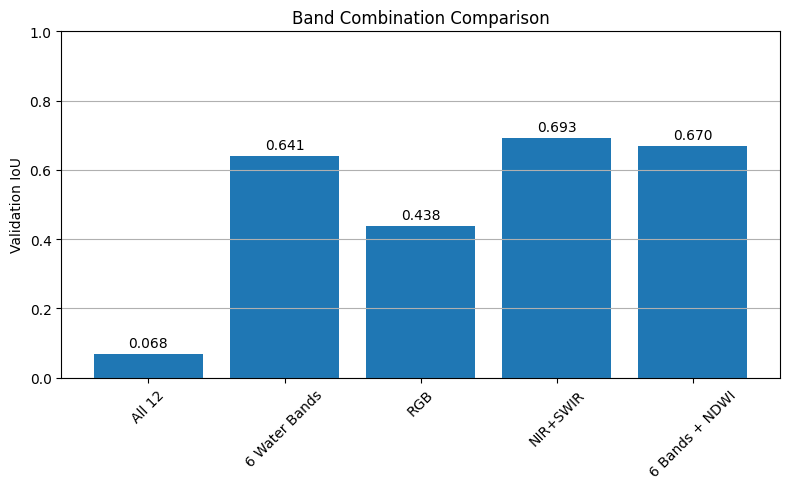

In [45]:
import matplotlib.pyplot as plt

model_names = list(results.keys())
iou_scores = list(results.values())

plt.figure(figsize=(8,5))
plt.bar(model_names, iou_scores)
plt.xticks(rotation=45)
plt.ylabel("Validation IoU")
plt.title("Band Combination Comparison")
plt.ylim(0, 1)
plt.grid(axis="y")

for i, v in enumerate(iou_scores):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()


### Model A (6 Bands)

In [20]:
selected_bands = [0, 1, 4, 5, 6, 11]

class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)


        with rasterio.open(img_path) as src:
            image = src.read()  

        image = np.transpose(image, (1, 2, 0))  
        image = image[:, :, selected_bands]
        image = image.astype(np.float32)


        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            raise ValueError(f"Mask not found: {mask_path}")

        mask = (mask > 0).astype(np.float32)  
        image = torch.tensor(image).permute(2, 0, 1)  
        mask = torch.tensor(mask).unsqueeze(0)       

        return image, mask


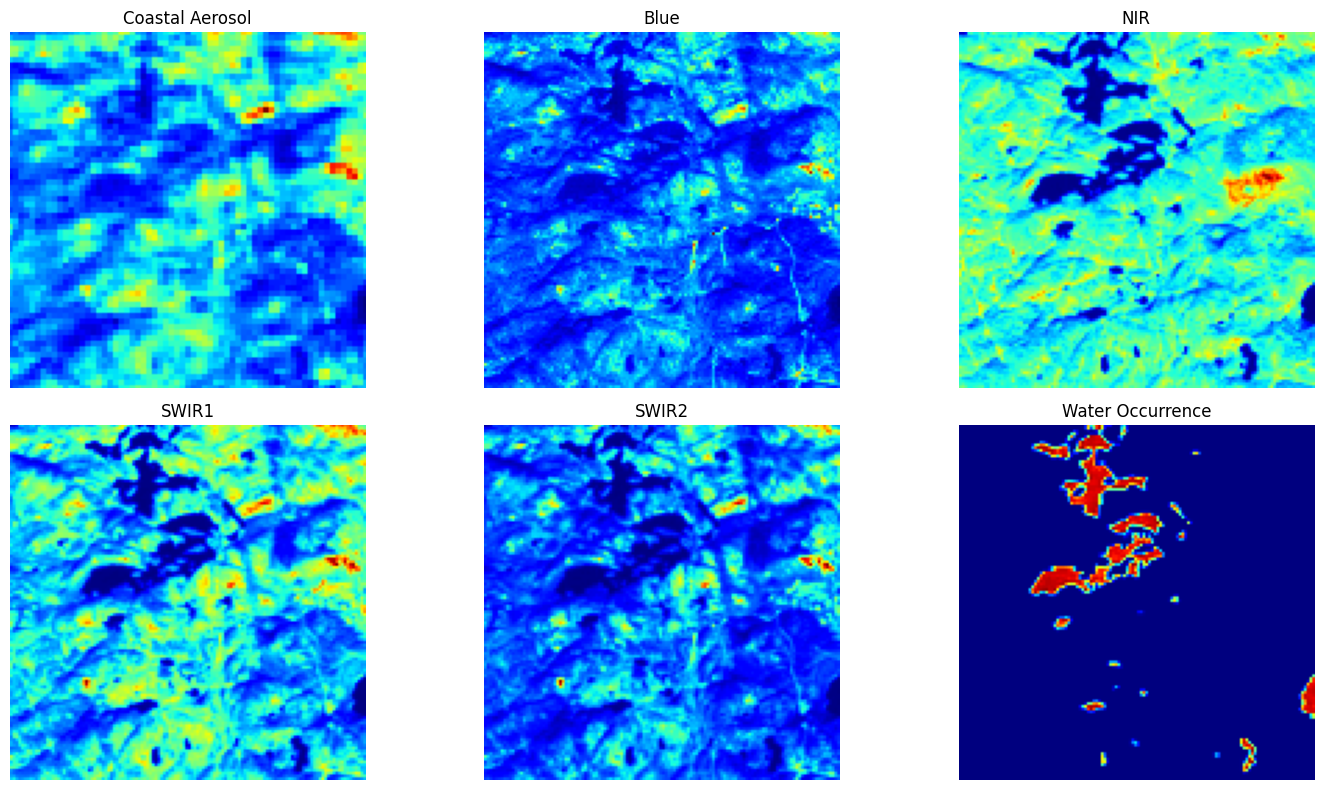

In [21]:
plt.figure(figsize=(15,8))

band_names = [
    "Coastal Aerosol",
    "Blue",
    "NIR",
    "SWIR1",
    "SWIR2",
    "Water Occurrence"
]

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(sample_image[:,:,selected_bands[i]], cmap='jet')
    plt.title(band_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


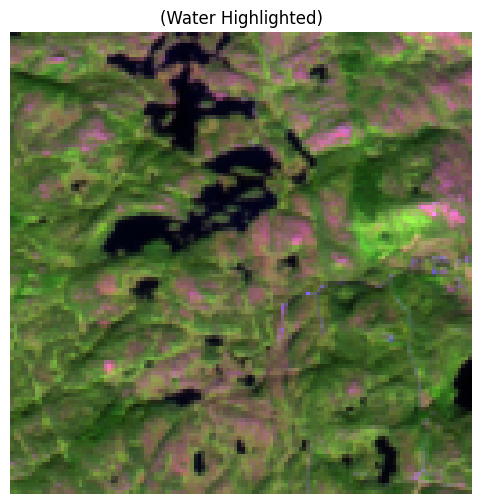

In [22]:
nir = sample_image[:,:,4]
swir1 = sample_image[:,:,5]
blue = sample_image[:,:,1]

rgb_water = np.stack([swir1, nir, blue], axis=-1)

plt.figure(figsize=(6,6))
plt.imshow(rgb_water)
plt.title("(Water Highlighted)")
plt.axis("off")
plt.show()


In [23]:
from torch.utils.data import Subset

full_dataset = WaterDataset(image_dir, label_dir)
indices = list(range(len(full_dataset)))

train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, random_state=42)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))


Train size: 214
Validation size: 46
Test size: 46


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=6, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4 , weight_decay=1e-4)


In [25]:
import matplotlib.pyplot as plt

epochs = 20

train_losses = []
val_losses = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []

def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)

    return iou.item(), dice.item()


for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    train_iou = 0
    train_dice = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        iou, dice = calculate_metrics(preds, masks)
        train_iou += iou
        train_dice += dice

        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)
    train_dice /= len(train_loader)

    train_losses.append(train_loss)
    train_ious.append(train_iou)
    train_dices.append(train_dice)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_iou = 0
    val_dice = 0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou, dice = calculate_metrics(preds, masks)
            val_iou += iou
            val_dice += dice

            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_dice /= len(val_loader)

    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_dices.append(val_dice)

    print(f"\nEpoch {epoch+1}")
    print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f} | Dice:{train_dice:.4f}")
    print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f} | Dice:{val_dice:.4f}\n")


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.31it/s, val_loss=0.629]



Epoch 1
Train -> Loss:0.5085 | IoU:0.5488 | Dice:0.7000
Val   -> Loss:0.6373 | IoU:0.3139 | Dice:0.4656



Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  5.75it/s, val_loss=0.484]



Epoch 2
Train -> Loss:0.3955 | IoU:0.6501 | Dice:0.7843
Val   -> Loss:0.4939 | IoU:0.3582 | Dice:0.5164



Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s, val_loss=0.385]



Epoch 3
Train -> Loss:0.3788 | IoU:0.6497 | Dice:0.7829
Val   -> Loss:0.3848 | IoU:0.5848 | Dice:0.7354



Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.10it/s, val_loss=0.368]



Epoch 4
Train -> Loss:0.3588 | IoU:0.6580 | Dice:0.7911
Val   -> Loss:0.3692 | IoU:0.6380 | Dice:0.7775



Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.10it/s, val_loss=0.346]



Epoch 5
Train -> Loss:0.3451 | IoU:0.6793 | Dice:0.8062
Val   -> Loss:0.3426 | IoU:0.6375 | Dice:0.7757



Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s, val_loss=0.34] 



Epoch 6
Train -> Loss:0.3445 | IoU:0.6587 | Dice:0.7855
Val   -> Loss:0.3352 | IoU:0.6485 | Dice:0.7858



Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s, val_loss=0.337]



Epoch 7
Train -> Loss:0.3337 | IoU:0.6712 | Dice:0.8006
Val   -> Loss:0.3327 | IoU:0.6783 | Dice:0.8078



Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.51it/s, val_loss=0.424]



Epoch 8
Train -> Loss:0.3184 | IoU:0.6899 | Dice:0.8137
Val   -> Loss:0.3902 | IoU:0.6416 | Dice:0.7797



Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.89it/s, val_loss=0.307]



Epoch 9
Train -> Loss:0.3159 | IoU:0.6900 | Dice:0.8145
Val   -> Loss:0.3126 | IoU:0.6933 | Dice:0.8182



Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  5.48it/s, val_loss=0.396]



Epoch 10
Train -> Loss:0.3252 | IoU:0.6519 | Dice:0.7833
Val   -> Loss:0.3901 | IoU:0.6364 | Dice:0.7768



Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.36it/s, val_loss=0.301]



Epoch 11
Train -> Loss:0.3039 | IoU:0.6981 | Dice:0.8172
Val   -> Loss:0.3046 | IoU:0.6811 | Dice:0.8093



Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.33it/s, val_loss=0.282]



Epoch 12
Train -> Loss:0.2969 | IoU:0.7107 | Dice:0.8285
Val   -> Loss:0.2856 | IoU:0.7020 | Dice:0.8238



Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.87it/s, val_loss=0.268]



Epoch 13
Train -> Loss:0.3122 | IoU:0.6765 | Dice:0.8004
Val   -> Loss:0.2845 | IoU:0.6993 | Dice:0.8221



Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.67it/s, val_loss=0.275]



Epoch 14
Train -> Loss:0.2991 | IoU:0.6777 | Dice:0.7998
Val   -> Loss:0.2946 | IoU:0.7004 | Dice:0.8232



Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.17it/s, val_loss=0.268]



Epoch 15
Train -> Loss:0.3020 | IoU:0.6738 | Dice:0.8037
Val   -> Loss:0.2818 | IoU:0.7032 | Dice:0.8253



Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.48it/s, val_loss=0.264]



Epoch 16
Train -> Loss:0.2866 | IoU:0.6938 | Dice:0.8142
Val   -> Loss:0.2772 | IoU:0.7107 | Dice:0.8296



Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.04it/s, val_loss=0.245]



Epoch 17
Train -> Loss:0.2806 | IoU:0.6989 | Dice:0.8212
Val   -> Loss:0.2644 | IoU:0.6964 | Dice:0.8191



Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.55it/s, val_loss=0.265]



Epoch 18
Train -> Loss:0.2618 | IoU:0.7380 | Dice:0.8480
Val   -> Loss:0.2657 | IoU:0.7245 | Dice:0.8384



Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.57it/s, val_loss=0.239]



Epoch 19
Train -> Loss:0.2617 | IoU:0.7236 | Dice:0.8327
Val   -> Loss:0.2552 | IoU:0.7280 | Dice:0.8414



Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.60it/s, val_loss=0.229]


Epoch 20
Train -> Loss:0.2544 | IoU:0.7223 | Dice:0.8334
Val   -> Loss:0.2460 | IoU:0.7311 | Dice:0.8437



In [26]:
model.eval()

TP = FP = FN = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.2).float()

        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\nEval:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"F1-score:  {f1:.4f}")


Testing: 100%|██████████| 3/3 [00:00<00:00,  6.54it/s]


Eval:
Precision: 0.6331
Recall:    0.9015
IoU:       0.5921
F1-score:  0.7438


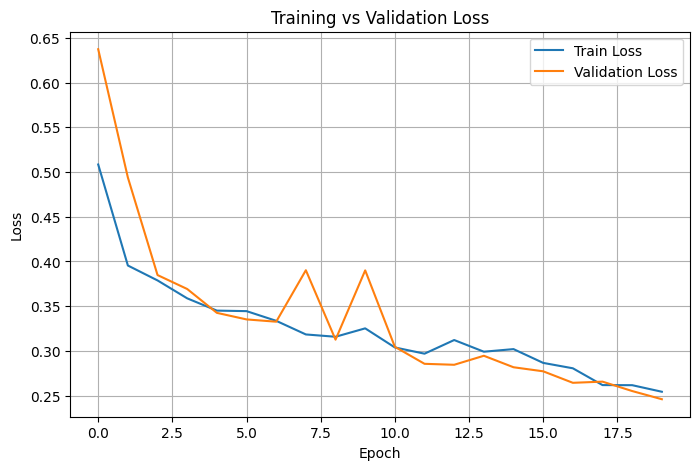

In [27]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


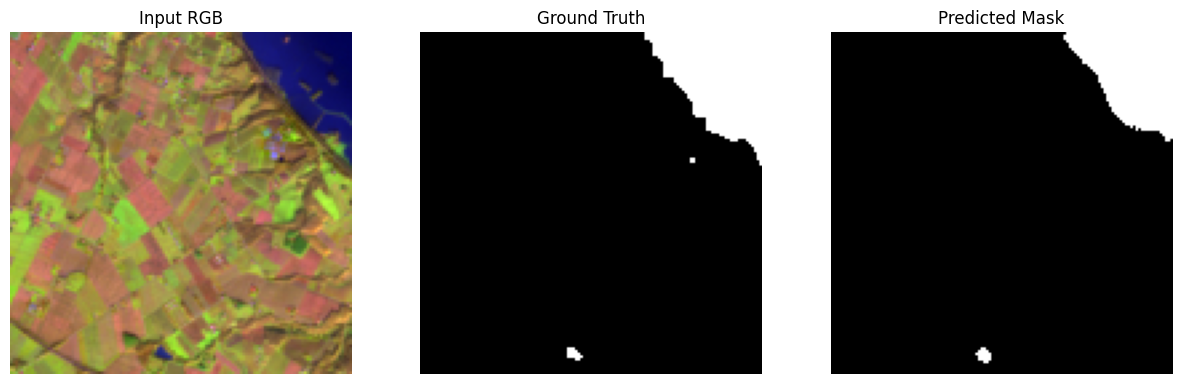

In [28]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    preds = (outputs > 0.5).float()

# Move to CPU
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0][0]
pred = preds[0][0]

rgb = torch.stack([img[3], img[2], img[1]], dim=0)
rgb = rgb.permute(1,2,0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


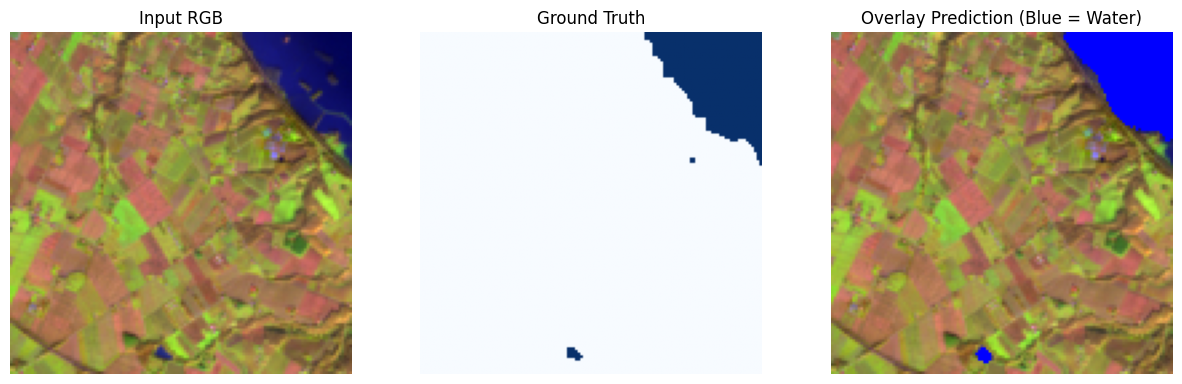

In [29]:
rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()


### Model B (6 Bands + NDWI)

In [ ]:
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))

        self.selected_bands = [0, 1, 4, 5, 6, 11]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)

        with rasterio.open(img_path) as src:
            full_image = src.read()  

        full_image = np.transpose(full_image, (1,2,0)).astype(np.float32)
        image = full_image[:, :, self.selected_bands]

        green = full_image[:, :, 2]
        nir = full_image[:, :, 4]

        ndwi = (green - nir) / (green + nir + 1e-8)
        ndwi = np.expand_dims(ndwi, axis=-1)
        image = np.concatenate([image, ndwi], axis=-1)

        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        image = torch.tensor(image).permute(2,0,1)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=7, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4 , weight_decay=1e-4)


In [32]:
dataset = WaterDataset(image_dir, label_dir)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [33]:
import matplotlib.pyplot as plt

epochs = 20

train_losses = []
val_losses = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []

def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)

    return iou.item(), dice.item()


for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    train_iou = 0
    train_dice = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        iou, dice = calculate_metrics(preds, masks)
        train_iou += iou
        train_dice += dice

        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)
    train_dice /= len(train_loader)

    train_losses.append(train_loss)
    train_ious.append(train_iou)
    train_dices.append(train_dice)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_iou = 0
    val_dice = 0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou, dice = calculate_metrics(preds, masks)
            val_iou += iou
            val_dice += dice

            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_dice /= len(val_loader)

    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_dices.append(val_dice)

    print(f"\nEpoch {epoch+1}")
    print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f} | Dice:{train_dice:.4f}")
    print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f} | Dice:{val_dice:.4f}\n")


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.88it/s, val_loss=0.673]



Epoch 1
Train -> Loss:0.5888 | IoU:0.4143 | Dice:0.5733
Val   -> Loss:0.6748 | IoU:0.5493 | Dice:0.7063



Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.66it/s, val_loss=0.556]



Epoch 2
Train -> Loss:0.4506 | IoU:0.6154 | Dice:0.7534
Val   -> Loss:0.5387 | IoU:0.4029 | Dice:0.5739



Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.91it/s, val_loss=0.454]



Epoch 3
Train -> Loss:0.4220 | IoU:0.6322 | Dice:0.7702
Val   -> Loss:0.4182 | IoU:0.6462 | Dice:0.7840



Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.62it/s, val_loss=0.393]



Epoch 4
Train -> Loss:0.3909 | IoU:0.6772 | Dice:0.8056
Val   -> Loss:0.3653 | IoU:0.6878 | Dice:0.8143



Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  5.78it/s, val_loss=0.384]



Epoch 5
Train -> Loss:0.4048 | IoU:0.5993 | Dice:0.7338
Val   -> Loss:0.3520 | IoU:0.7027 | Dice:0.8250



Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.99it/s, val_loss=0.406]



Epoch 6
Train -> Loss:0.3666 | IoU:0.6844 | Dice:0.8108
Val   -> Loss:0.3895 | IoU:0.6770 | Dice:0.8069



Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.87it/s, val_loss=0.384]



Epoch 7
Train -> Loss:0.3668 | IoU:0.6570 | Dice:0.7870
Val   -> Loss:0.3623 | IoU:0.6930 | Dice:0.8180



Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.68it/s, val_loss=0.363]



Epoch 8
Train -> Loss:0.3800 | IoU:0.6101 | Dice:0.7433
Val   -> Loss:0.3337 | IoU:0.6935 | Dice:0.8186



Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s, val_loss=0.428]



Epoch 9
Train -> Loss:0.3534 | IoU:0.6620 | Dice:0.7903
Val   -> Loss:0.3929 | IoU:0.6438 | Dice:0.7819



Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.91it/s, val_loss=0.359]



Epoch 10
Train -> Loss:0.3414 | IoU:0.6771 | Dice:0.8051
Val   -> Loss:0.3310 | IoU:0.7066 | Dice:0.8276



Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.52it/s, val_loss=0.362]



Epoch 11
Train -> Loss:0.3279 | IoU:0.7006 | Dice:0.8200
Val   -> Loss:0.3261 | IoU:0.7005 | Dice:0.8232



Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.71it/s, val_loss=0.351]



Epoch 12
Train -> Loss:0.3186 | IoU:0.7094 | Dice:0.8283
Val   -> Loss:0.3143 | IoU:0.7233 | Dice:0.8389



Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s, val_loss=0.338]



Epoch 13
Train -> Loss:0.3117 | IoU:0.7014 | Dice:0.8202
Val   -> Loss:0.3086 | IoU:0.7237 | Dice:0.8392



Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.70it/s, val_loss=0.369]



Epoch 14
Train -> Loss:0.3175 | IoU:0.6782 | Dice:0.8005
Val   -> Loss:0.3363 | IoU:0.6934 | Dice:0.8186



Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.12it/s, val_loss=0.326]



Epoch 15
Train -> Loss:0.3224 | IoU:0.6650 | Dice:0.7919
Val   -> Loss:0.2946 | IoU:0.7214 | Dice:0.8378



Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.52it/s, val_loss=0.378]



Epoch 16
Train -> Loss:0.3081 | IoU:0.6888 | Dice:0.8081
Val   -> Loss:0.3379 | IoU:0.6902 | Dice:0.8163



Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s, val_loss=0.373]



Epoch 17
Train -> Loss:0.2951 | IoU:0.7146 | Dice:0.8303
Val   -> Loss:0.3112 | IoU:0.6954 | Dice:0.8198



Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s, val_loss=0.339]



Epoch 18
Train -> Loss:0.3035 | IoU:0.6759 | Dice:0.7987
Val   -> Loss:0.2971 | IoU:0.7107 | Dice:0.8301



Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s, val_loss=0.328]



Epoch 19
Train -> Loss:0.2930 | IoU:0.7253 | Dice:0.8388
Val   -> Loss:0.2814 | IoU:0.7099 | Dice:0.8301



Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s, val_loss=0.313]


Epoch 20
Train -> Loss:0.2920 | IoU:0.6844 | Dice:0.8094
Val   -> Loss:0.2785 | IoU:0.7350 | Dice:0.8469



In [34]:
model.eval()

TP = FP = FN = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.2).float()

        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\nEval:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"F1-score:  {f1:.4f}")


Testing: 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]


Eval:
Precision: 0.5679
Recall:    0.9028
IoU:       0.5351
F1-score:  0.6972


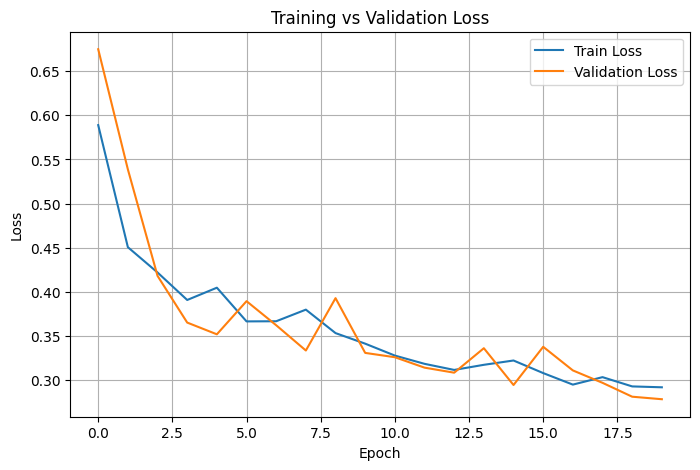

In [37]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


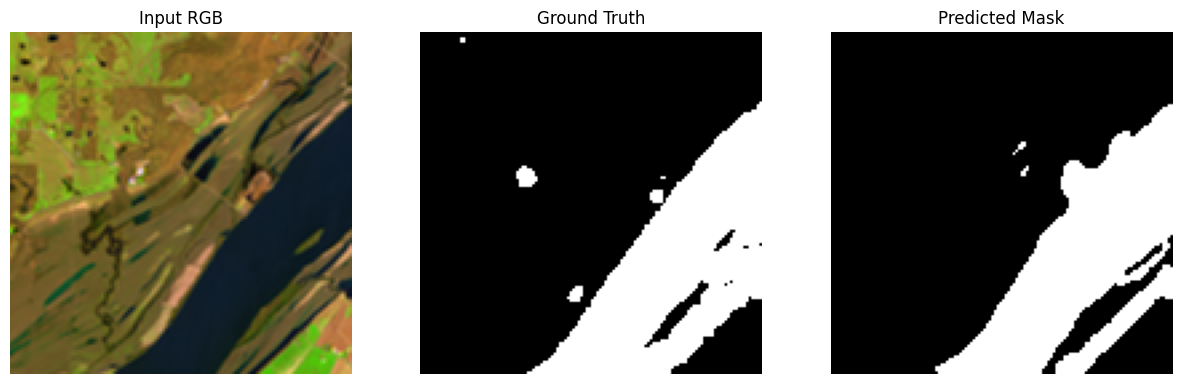

In [38]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    preds = (outputs > 0.5).float()

# Move to CPU
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0][0]
pred = preds[0][0]

rgb = torch.stack([img[3], img[2], img[1]], dim=0)
rgb = rgb.permute(1,2,0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


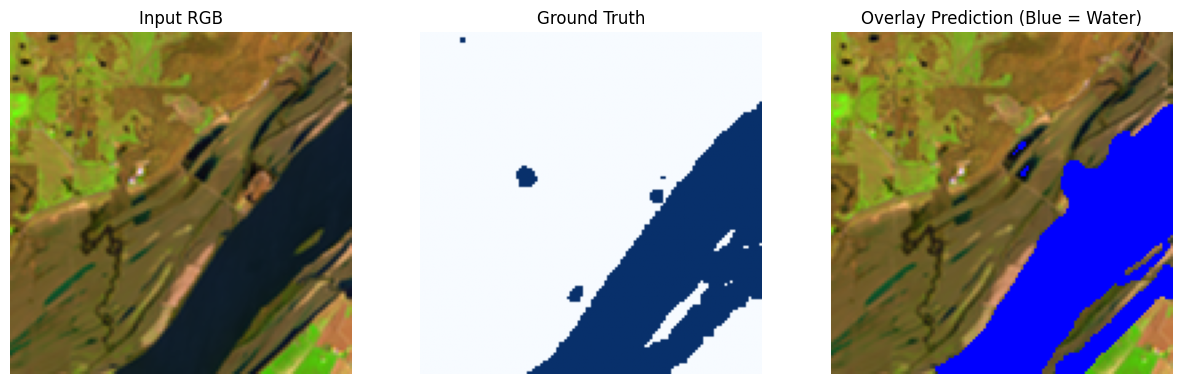

In [39]:
rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()
